Import Libraries

In [929]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score


In [930]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [931]:
train_path = "./Datasets/train.csv"
test_path = "./Datasets/test.csv"

mall_train_path = "./Datasets/mall_train.csv"
mall_test_path = "./Datasets/mall_test.csv"
mrt_train_path = "./Datasets/mrt-train.csv"
mrt_test_path = "./Datasets/mrt_test.csv"
school_train_path = "./Datasets/school_train.csv"
school_test_path = "./Datasets/school_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

mall_test = pd.read_csv(mall_test_path)
mall_train = pd.read_csv(mall_train_path)
mrt_train = pd.read_csv(mrt_train_path)
mrt_test = pd.read_csv(mrt_test_path)
school_train = pd.read_csv(school_train_path)
school_test = pd.read_csv(school_test_path)


In [932]:
mrt_columns = ['MRT_1km', 'nearest_MRT_dis', 'mrt_average_price']
train_data[mrt_columns] = mrt_train[mrt_columns]
test_data[mrt_columns] = mrt_test[mrt_columns]

school_columns = ['nearest_school_dis', 'nearest_school_name']
train_data[school_columns] = school_train[school_columns]
test_data[school_columns] = school_test[school_columns]

mall_columns = ['nearest_mall_dis', 'nearest_mall_name']
train_data[mall_columns] = mall_train[mall_columns]
test_data[mall_columns] = mall_test[mall_columns]

See train data distribution

In [933]:
train_data.shape

(60000, 23)

In [934]:
train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_dis,mrt_average_price,nearest_school_dis,nearest_school_name,nearest_mall_dis,nearest_mall_name
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,jurong east,west region,1600,1.0,0.200699,2481.346424,0.334495,Yuhua Primary School,1.197252,Westgate
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,...,bedok,east region,2250,1.0,0.000923,2425.980392,0.605547,St. Anthony's Canossian Primary School,1.114364,Djitsun Mall Bedok
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,...,toa payoh,central region,1900,4.0,0.518801,2632.947462,0.426187,CHIJ Primary (Toa Payoh),0.468813,HDB Hub
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,...,pasir ris,east region,2850,0.0,-0.647366,2687.550471,0.562392,Pasir Ris Primary School,0.400741,Loyang Point
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,...,kallang,central region,2100,3.0,0.487930,2589.985486,0.271506,Bendemeer Primary School,1.067395,Aperia


In [935]:
train_data.nunique()

rent_approval_date       31
town                     26
block                  2553
street_name            1083
flat_type                 9
flat_model               19
floor_area_sqm          146
furnished                 1
lease_commence_date      54
latitude               8612
longitude              8612
elevation                 1
subzone                 152
planning_area            29
region                    5
monthly_rent            113
MRT_1km                  15
nearest_MRT_dis        8630
mrt_average_price        96
nearest_school_dis     8612
nearest_school_name     164
nearest_mall_dis       8610
nearest_mall_name       114
dtype: int64

In [936]:
train_data.isna().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
MRT_1km                0
nearest_MRT_dis        0
mrt_average_price      0
nearest_school_dis     0
nearest_school_name    0
nearest_mall_dis       0
nearest_mall_name      0
dtype: int64

Data preprocessing of train_data

In [937]:
def data_preprocessing(data):
    data.replace("-", " ", regex=True, inplace=True)

    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.lower()
    
    data['lease_commence_date'] = 2021 - data['lease_commence_date']

    def convert_to_numeric(date_str):
        year, month = date_str.split(" ")
        return float(year) + float(month)/12.0
    data['rent_approval_date'] = [convert_to_numeric(date) for date in data['rent_approval_date']]

    data['rent_approval_date'] = data['rent_approval_date'] - 2021
    
    # data = data.drop_duplicates()
    # data = data.reset_index(drop=True)
    # data['monthly_rent'] = np.log1p(data['monthly_rent'])
    # data.drop(data[(data['floor_area_sqm']<30)].index, inplace=True)
    # data.drop(data[(data['floor_area_sqm']>160)].index, inplace=True)
    # data.drop(data[(data['monthly_rent']>6000)].index, inplace=True)
    # data.drop(data[(data['monthly_rent']<500)].index, inplace=True)
    
    return data

train_data = data_preprocessing(train_data)
train_data


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_dis,mrt_average_price,nearest_school_dis,nearest_school_name,nearest_mall_dis,nearest_mall_name
0,0.750000,jurong east,257,jurong east street 24,3 room,new generation,67.0,yes,38,1.344518,...,jurong east,west region,1600,1.0,0.200699,2481.346424,0.334495,yuhua primary school,1.197252,westgate
1,1.416667,bedok,119,bedok north road,4 room,new generation,92.0,yes,43,1.330186,...,bedok,east region,2250,1.0,0.000923,2425.980392,0.605547,st. anthony's canossian primary school,1.114364,djitsun mall bedok
2,1.833333,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,50,1.332242,...,toa payoh,central region,1900,4.0,0.518801,2632.947462,0.426187,chij primary (toa payoh),0.468813,hdb hub
3,0.666667,pasir ris,250,pasir ris street 21,executive,apartment,149.0,yes,28,1.370239,...,pasir ris,east region,2850,0.0,-0.647366,2687.550471,0.562392,pasir ris primary school,0.400741,loyang point
4,1.916667,kallang/whampoa,34,whampoa west,3 room,improved,68.0,yes,49,1.320502,...,kallang,central region,2100,3.0,0.487930,2589.985486,0.271506,bendemeer primary school,1.067395,aperia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.750000,ang mo kio,441,ang mo kio avenue 10,3 room,new generation,67.0,yes,42,1.366050,...,ang mo kio,north east region,2200,1.0,0.231013,2461.518550,0.361006,ang mo kio primary school,0.947922,jubilee square
59996,2.333333,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2,1.286493,...,bukit merah,central region,4100,2.0,0.279747,2881.436907,0.562558,zhangde primary school,0.741501,tiong bahru plaza
59997,1.500000,tampines,862a,tampines street 83,5 room,improved,122.0,yes,33,1.355064,...,tampines,east region,2250,2.0,0.176264,2643.672840,0.318659,poi ching school,0.439827,our tampines hub
59998,2.083333,bedok,67,bedok sth avenue 3,5 room,standard,123.0,yes,44,1.318974,...,bedok,east region,4700,1.0,-0.018778,2425.980392,0.219191,temasek primary school,1.775637,bedok mall


Feature Engineering of train_data

In [938]:
X_train_num = train_data.select_dtypes(include = ['float64', 'int64'])
print(X_train_num.shape)
X_train_num.head()

(60000, 12)


,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent,MRT_1km,nearest_MRT_dis,mrt_average_price,nearest_school_dis,nearest_mall_dis
0,0.750000,67.0,38,1.344518,103.738630,0.0,1600,1.0,0.200699,2481.346424,0.334495,1.197252
1,1.416667,92.0,43,1.330186,103.938717,0.0,2250,1.0,0.000923,2425.980392,0.605547,1.114364
2,1.833333,67.0,50,1.332242,103.845643,0.0,1900,4.0,0.518801,2632.947462,0.426187,0.468813
3,0.666667,149.0,28,1.370239,103.962894,0.0,2850,0.0,-0.647366,2687.550471,0.562392,0.400741
4,1.916667,68.0,49,1.320502,103.863341,0.0,2100,3.0,0.487930,2589.985486,0.271506,1.067395


In [939]:
X_train_cat = train_data.select_dtypes(include = ['object'])
print(X_train_cat.shape)
X_train_cat.head()

(60000, 11)


,town,block,street_name,flat_type,flat_model,furnished,subzone,planning_area,region,nearest_school_name,nearest_mall_name
0,jurong east,257,jurong east street 24,3 room,new generation,yes,yuhua east,jurong east,west region,yuhua primary school,westgate
1,bedok,119,bedok north road,4 room,new generation,yes,bedok north,bedok,east region,st. anthony's canossian primary school,djitsun mall bedok
2,toa payoh,157,lorong 1 toa payoh,3 room,improved,yes,toa payoh central,toa payoh,central region,chij primary (toa payoh),hdb hub
3,pasir ris,250,pasir ris street 21,executive,apartment,yes,pasir ris drive,pasir ris,east region,pasir ris primary school,loyang point
4,kallang/whampoa,34,whampoa west,3 room,improved,yes,bendemeer,kallang,central region,bendemeer primary school,aperia


array([[<AxesSubplot:title={'center':'rent_approval_date'}>,
        <AxesSubplot:title={'center':'floor_area_sqm'}>,
        <AxesSubplot:title={'center':'lease_commence_date'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'elevation'}>],
       [<AxesSubplot:title={'center':'monthly_rent'}>,
        <AxesSubplot:title={'center':'MRT_1km'}>,
        <AxesSubplot:title={'center':'nearest_MRT_dis'}>],
       [<AxesSubplot:title={'center':'mrt_average_price'}>,
        <AxesSubplot:title={'center':'nearest_school_dis'}>,
        <AxesSubplot:title={'center':'nearest_mall_dis'}>]], dtype=object)

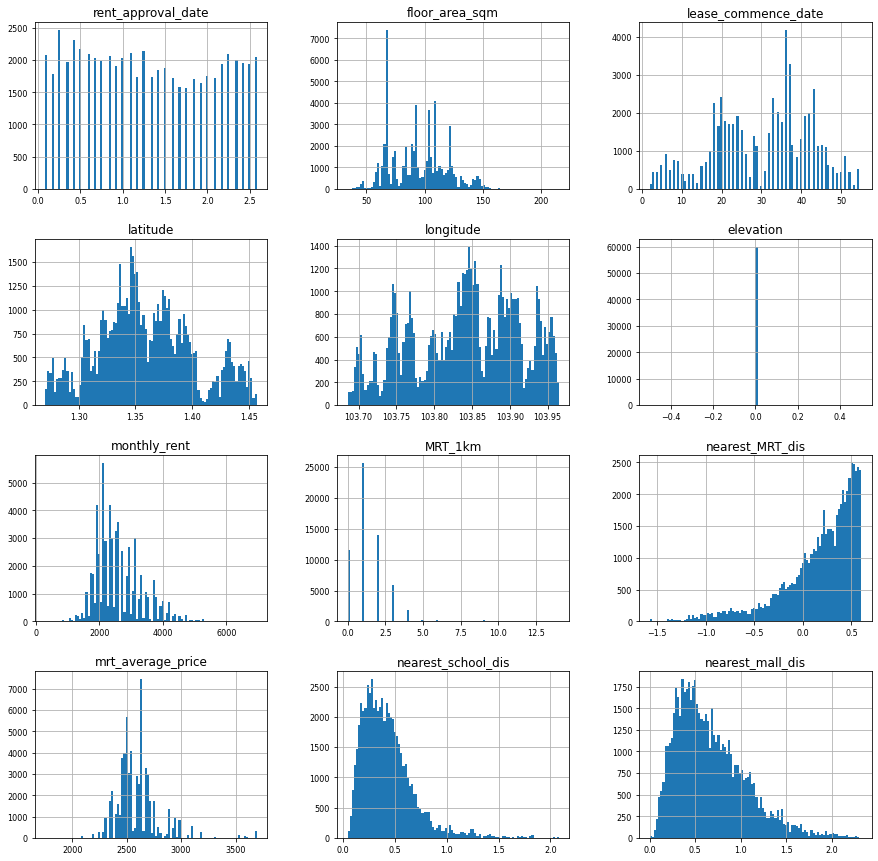

In [940]:
X_train_num.hist(figsize=(15, 15), bins=100, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

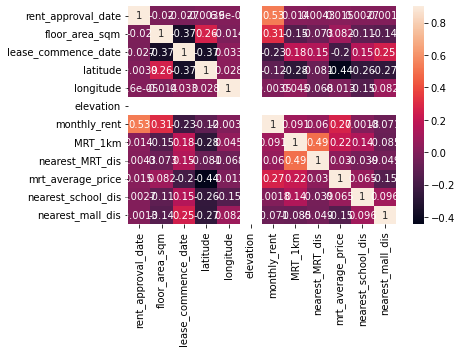

In [941]:
corrmat = X_train_num.corr()
sns.heatmap(corrmat, vmax=.9, annot=True)

count    60000.000000
mean      2590.328333
std        714.910468
min        300.000000
25%       2100.000000
50%       2400.000000
75%       3000.000000
max       6950.000000
Name: monthly_rent, dtype: float64


<Figure size 432x288 with 0 Axes>

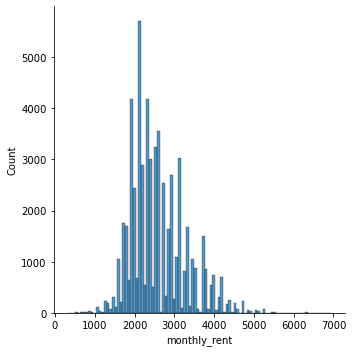

In [942]:
y_train = train_data['monthly_rent']
print(y_train.describe())
plt.figure()
sns.displot(y_train, bins=100)

In [943]:
def feature_engineering(data):
    # numerical feature
    data_num = data.select_dtypes(include = ['float64', 'int64'])
    data_num = data_num[['rent_approval_date', 'floor_area_sqm', 'lease_commence_date','mrt_average_price','MRT_1km', 'nearest_MRT_dis', 'nearest_school_dis']] # 'nearest_mall_dis'

    # categorical feature
    data_cat = data.select_dtypes(include = ['object'])
    data_cat_one_hot = pd.get_dummies(data[['region']]) #'flat_type' , 'planning_area', 'town', 'flat_model'

    data_cat_target = pd.DataFrame()

    # region_encoded = train_data.groupby('region')['monthly_rent'].mean()
    # data_cat_target['region_encoded'] = data['region'].map(region_encoded)
    
    town_encoded = train_data.groupby('town')['monthly_rent'].mean()
    data_cat_target['town_encoded'] = data['town'].map(town_encoded)
    
    planning_area_encoded = train_data.groupby('planning_area')['monthly_rent'].mean()
    data_cat_target['planning_area_encoded'] = data['planning_area'].map(planning_area_encoded)

    subzone_encoded = train_data.groupby('subzone')['monthly_rent'].mean()
    data_cat_target['subzone_encoded'] = data['subzone'].map(subzone_encoded)

    flat_model_encoded = train_data.groupby('flat_model')['monthly_rent'].mean()
    data_cat_target['flat_model_encoded'] = data['flat_model'].map(flat_model_encoded)

    flat_type_encoded = train_data.groupby('flat_type')['monthly_rent'].mean()
    data_cat_target['flat_type_encoded'] = data['flat_type'].map(flat_type_encoded)

    # block_encoded = train_data.groupby('block')['monthly_rent'].median().transform(lambda x: int(x / 1000) * 1000)
    # data_cat_target['block_encoded'] = data['block'].map(block_encoded)

    street_name_encoded = train_data.groupby('street_name')['monthly_rent'].mean()
    data_cat_target['street_name_encoded'] = data['street_name'].map(street_name_encoded)

    # nearest_mall_name_encoded = train_data.groupby('nearest_mall_name')['monthly_rent'].mean()
    # data_cat_target['nearest_mall_name_encoded'] = data['nearest_mall_name'].map(nearest_mall_name_encoded)

    # nearest_school_name_encoded = train_data.groupby('nearest_school_name')['monthly_rent'].mean()
    # data_cat_target['nearest_school_name_encoded'] = data['nearest_school_name'].map(nearest_school_name_encoded)

    # data_cat_target['town_encoded'] = train_data.groupby('town')['monthly_rent'].transform('mean')
    # data_cat_target['planning_area_encoded'] = train_data.groupby('planning_area')['monthly_rent'].transform('mean')
    # data_cat_target['block_encoded'] = train_data.groupby('block')['monthly_rent'].transform('mean')
    # data_cat_target['street_name_encoded'] = train_data.groupby('street_name')['monthly_rent'].transform('mean')

    # Concate all the choosed features
    # data_filter = pd.concat([data_num, data_cat_target], axis=1)
    data_filter = pd.concat([data_num, data_cat_one_hot, data_cat_target], axis=1)

    return data_filter

X_train = feature_engineering(train_data)
X_train
    

,rent_approval_date,floor_area_sqm,lease_commence_date,mrt_average_price,MRT_1km,nearest_MRT_dis,nearest_school_dis,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded,flat_type_encoded,street_name_encoded
0,0.750000,67.0,38,2481.346424,1.0,0.200699,0.334495,False,False,False,False,True,2595.146199,2595.146199,2542.158516,2369.965462,2276.033233,2312.179487
1,1.416667,92.0,43,2425.980392,1.0,0.000923,0.605547,False,True,False,False,False,2438.227223,2438.227223,2360.371046,2369.965462,2692.359176,2404.212860
2,1.833333,67.0,50,2632.947462,4.0,0.518801,0.426187,True,False,False,False,False,2516.680515,2516.680515,2808.893871,2636.211052,2276.033233,2403.464419
3,0.666667,149.0,28,2687.550471,0.0,-0.647366,0.562392,False,True,False,False,False,2686.857477,2686.857477,2610.338573,2878.725962,2892.857143,2757.834101
4,1.916667,68.0,49,2589.985486,3.0,0.487930,0.271506,True,False,False,False,False,2665.537634,2702.635659,2793.525180,2636.211052,2276.033233,2395.744681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.750000,67.0,42,2461.518550,1.0,0.231013,0.361006,False,False,True,False,False,2416.700057,2416.700057,2390.887097,2369.965462,2276.033233,2336.012658
59996,2.333333,83.0,2,2881.436907,2.0,0.279747,0.562558,True,False,False,False,False,2904.113924,2904.113924,2694.936709,2612.031305,2692.359176,3400.000000
59997,1.500000,122.0,33,2643.672840,2.0,0.176264,0.318659,False,True,False,False,False,2638.489123,2638.489123,2602.823315,2636.211052,2815.593875,2509.600000
59998,2.083333,123.0,44,2425.980392,1.0,-0.018778,0.219191,False,True,False,False,False,2438.227223,2438.227223,2434.379786,2444.223986,2815.593875,2591.447368


## Start to train

### Training preparation

#### Train-Test Split

In [944]:
X, y = X_train, y_train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Define evaluation metrics

In [945]:
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
#     return rmse

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))

    
    print("MAE:", mae)
    print("R2 Score:", r_squared)
    print("MSE:", mse)
    print("RMSE:", rmse)
    

### Linear Models

#### Linear Regression(Ordinary Least Squares)

In [533]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 390.1860419536994
R2 Score: 0.4985588683893154
MSE: 252964.99916915418
RMSE: 502.95625969775364


#### Ridge Regression

In [870]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

evaluation(y_test, predictions)

MAE: 398.7439469219966
R2 Score: 0.4737315108081247
MSE: 265489.80436358385
RMSE: 515.257027476175


#### Lasso Regression

In [871]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

evaluation(y_test, predictions)

MAE: 399.80348268392635
R2 Score: 0.47096319202306414
MSE: 266886.3546563638
RMSE: 516.6104476840976


#### Elastic-Net Regression

In [872]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

evaluation(y_test, predictions)

MAE: 436.11069171060103
R2 Score: 0.37995299261198767
MSE: 312798.81290337077
RMSE: 559.2841969011557


#### Stochastic Gradient Descent - SGD

In [873]:
scaler = StandardScaler()
X_train_sgd = scaler.fit_transform(X_train)
X_test_sgd = scaler.transform(X_test)

sgd = SGDRegressor(loss="epsilon_insensitive")
sgd.fit(X_train_sgd, y_train)
predictions = sgd.predict(X_test_sgd)

evaluation(y_test, predictions)

MAE: 398.7357454590873
R2 Score: 0.4662419139573436
MSE: 269268.1259684539
RMSE: 518.9105182673154


#### Polynomial regression

In [874]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

evaluation(y_test, predictions)

MAE: 377.17148761391064
R2 Score: 0.4852377075686024
MSE: 259685.20463997324
RMSE: 509.5931756214689


### Support Vector Machines

#### Support Vector Regression

In [875]:
svr = SVR(C=200000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

evaluation(y_test, predictions)

MAE: 425.2541070590775
R2 Score: 0.38444354209055087
MSE: 310533.43861812825
RMSE: 557.2552724004756


### Nearest Neighbors

#### Nearest Neighbors Regression

In [876]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=20)
knn_reg.fit(X_train_nn, y_train)
predictions = knn_reg.predict(X_test_nn)

evaluation(y_test, predictions)

MAE: 375.8364583333333
R2 Score: 0.508635186095417
MSE: 247881.7390625
RMSE: 497.8772329224344


### Decision Tree

#### DecisionTreeRegressor

In [877]:
tree_reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50)
tree_reg.fit(X_train, y_train)
predictions = tree_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 378.0424450075164
R2 Score: 0.5065345597328162
MSE: 248941.4545755915
RMSE: 498.9403316786402


### Ensemble Methods

#### Gradient-boosted trees

In [946]:
hist_reg = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01)
hist_reg.fit(X_train, y_train)
predictions = hist_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 365.21120083932965
R2 Score: 0.5396956612758805
MSE: 232212.4758471326
RMSE: 481.8842971576606


#### Random Forest

In [879]:
random_forest = RandomForestRegressor(n_estimators=1200,max_depth=15,min_samples_split=5,min_samples_leaf=5,max_features=None,oob_score=True)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

evaluation(y_test, predictions)

MAE: 372.15984447442816
R2 Score: 0.516109992133573
MSE: 244110.87906711415
RMSE: 494.07578271669433


#### BaggingRegressor

In [880]:
bag_reg = BaggingRegressor(n_estimators=100)
bag_reg.fit(X_train, y_train)
predictions = bag_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 404.97985204494296
R2 Score: 0.4211175726585705
MSE: 292032.271626962
RMSE: 540.4001032817832


#### AdaBoost Regressor

In [535]:
base_reg = LinearRegression()
ada_reg = AdaBoostRegressor(base_estimator=base_reg, n_estimators=1000)
ada_reg.fit(X_train, y_train)
predictions = ada_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 401.745205978806
R2 Score: 0.4728890789786009
MSE: 265914.790974417
RMSE: 515.6692651054715


#### XGBoost Regressor

In [947]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

evaluation(y_test, predictions)

MAE: 363.6385939737956
R2 Score: 0.5410505430693355
MSE: 231528.97054581292
RMSE: 481.1745738771043


#### Voting Regressor(Blend different regressors)

In [948]:
voting_reg = VotingRegressor(estimators=[('hist', hist_reg), ('xgb', xgb)])
voting_reg.fit(X_train, y_train)
predictions = voting_reg.predict(X_test)

evaluation(y_test, predictions)


MAE: 363.97040307536037
R2 Score: 0.5415059574464491
MSE: 231299.22493807203
RMSE: 480.93578047185474


### Neural network models (supervised)

#### MLP Regressor

In [884]:
mlp_reg = MLPRegressor(learning_rate='adaptive')
mlp_reg.fit(X_train, y_train)
predictions = mlp_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 397.4640958572571
R2 Score: 0.4641659851193336
MSE: 270315.38217397424
RMSE: 519.9186303393775


### Blend methods

In [951]:
def blended_pred(x):
    return 0.6 * xgb.predict(x) + 0.4 * hist_reg.predict(x) # + 0.05 * ada_reg.predict(x)


evaluation(y_test, blended_pred(X_test))

MAE: 363.84134301751334
R2 Score: 0.5415231903489275
MSE: 231290.5313529505
RMSE: 480.9267421894425


## Predict on test data

Predicet test dataset

In [952]:
test_data = data_preprocessing(test_data)
test_data = feature_engineering(test_data)

test_data

,rent_approval_date,floor_area_sqm,lease_commence_date,mrt_average_price,MRT_1km,nearest_MRT_dis,nearest_school_dis,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded,flat_type_encoded,street_name_encoded
0,2.083333,121.0,37,2529.932302,1.0,0.078970,0.149696,False,False,True,False,False,2503.252886,2503.252886,2427.604167,2636.211052,2815.593875,2335.714286
1,1.750000,100.0,22,2531.304665,1.0,0.593808,0.142556,False,False,False,True,False,2540.491010,2540.491010,2592.332790,2612.031305,2692.359176,2658.333333
2,2.583333,91.0,41,2636.174071,0.0,-0.192259,1.037485,False,False,False,False,True,2646.808979,2646.808979,2395.588235,2369.965462,2692.359176,2532.195122
3,0.666667,74.0,35,2481.346424,1.0,0.538309,1.076121,False,False,False,False,True,2595.146199,2595.146199,2400.150150,2612.031305,2276.033233,2781.756757
4,1.250000,121.0,38,2481.346424,1.0,0.452393,0.714777,False,False,False,False,True,2595.146199,2595.146199,2400.150150,2636.211052,2815.593875,2268.564356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.666667,92.0,9,2666.429094,1.0,0.024699,0.168533,False,False,True,False,False,2665.555556,2665.555556,2654.294479,2612.031305,2692.359176,2601.399491
29996,2.166667,90.0,17,2531.304665,1.0,0.071360,0.231490,False,False,False,True,False,2540.491010,2540.491010,2473.678647,2612.031305,2692.359176,2426.102941
29997,2.416667,68.0,41,2461.518550,1.0,0.356386,0.181335,False,False,True,False,False,2416.700057,2416.700057,2378.606965,2369.965462,2276.033233,2299.616368
29998,2.166667,144.0,23,2502.786033,1.0,0.457365,0.292592,False,False,False,True,False,2466.298251,2466.298251,2497.040971,2978.033473,2892.857143,2513.400000


In [953]:
test_data = test_data.reindex(columns=X_train.columns, fill_value=False)

test_data

,rent_approval_date,floor_area_sqm,lease_commence_date,mrt_average_price,MRT_1km,nearest_MRT_dis,nearest_school_dis,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded,flat_type_encoded,street_name_encoded
0,2.083333,121.0,37,2529.932302,1.0,0.078970,0.149696,False,False,True,False,False,2503.252886,2503.252886,2427.604167,2636.211052,2815.593875,2335.714286
1,1.750000,100.0,22,2531.304665,1.0,0.593808,0.142556,False,False,False,True,False,2540.491010,2540.491010,2592.332790,2612.031305,2692.359176,2658.333333
2,2.583333,91.0,41,2636.174071,0.0,-0.192259,1.037485,False,False,False,False,True,2646.808979,2646.808979,2395.588235,2369.965462,2692.359176,2532.195122
3,0.666667,74.0,35,2481.346424,1.0,0.538309,1.076121,False,False,False,False,True,2595.146199,2595.146199,2400.150150,2612.031305,2276.033233,2781.756757
4,1.250000,121.0,38,2481.346424,1.0,0.452393,0.714777,False,False,False,False,True,2595.146199,2595.146199,2400.150150,2636.211052,2815.593875,2268.564356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.666667,92.0,9,2666.429094,1.0,0.024699,0.168533,False,False,True,False,False,2665.555556,2665.555556,2654.294479,2612.031305,2692.359176,2601.399491
29996,2.166667,90.0,17,2531.304665,1.0,0.071360,0.231490,False,False,False,True,False,2540.491010,2540.491010,2473.678647,2612.031305,2692.359176,2426.102941
29997,2.416667,68.0,41,2461.518550,1.0,0.356386,0.181335,False,False,True,False,False,2416.700057,2416.700057,2378.606965,2369.965462,2276.033233,2299.616368
29998,2.166667,144.0,23,2502.786033,1.0,0.457365,0.292592,False,False,False,True,False,2466.298251,2466.298251,2497.040971,2978.033473,2892.857143,2513.400000


In [954]:
# best_model = voting_reg
# test_pred = best_model.predict(test_data)

test_pred = blended_pred(test_data)
test_pred

array([3194.56301287, 2801.05214392, 3350.17276713, ..., 2618.7849415 ,
       3276.34341135, 3445.72268753])

In [955]:
sample_submission_path = './Datasets/example-submission.csv'
sample_submission_df = pd.read_csv(sample_submission_path)
sample_submission_df['Predicted'] = test_pred
sample_submission_df.to_csv('./Datasets/submission.csv', index=False)
sample_submission_df.head()

,Id,Predicted
0,0,3194.563013
1,1,2801.052144
2,2,3350.172767
3,3,2078.627381
4,4,2567.504213
